## PURPOSE: simulate from the univariate plankton model

Illustrate: 
 * discretization and numerical solution (and built-in ODE solvers) 
 * adding stichasticity (additive white noise, stochastic parameters)
 * realization and ensembles for time series models

## setup:

In [1]:
import numpy as np

np.random.seed(7) # set random number seed if desired 

T = 365*4 # set duration of simulaton in days
dt = 1 # set time step (here 1 day)
nt = T*dt # determine model steps needed

γ = 0.25  # growth parameter
λ = 0.1 # mortality/loss parameter
om = 2*np.pi/365 # annual frequency 

In [2]:
P = np.full(nt, fill_value=np.nan)
P[0] = 2.5 # initial condition

for k in range(1,nt):
    time = k*dt
    P[k] = P[k-1] + dt*(γ*(1+np.sin(om*time))*P[k-1] - λ*P[k-1]**2)

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(0,dt*nt,dt), P)
None

In [4]:
from scipy.integrate import odeint

# ODE solver function
def Pgrowth(P, t, γ, λ):
    return γ *(1+np.sin(om*t))*P - λ*P**2

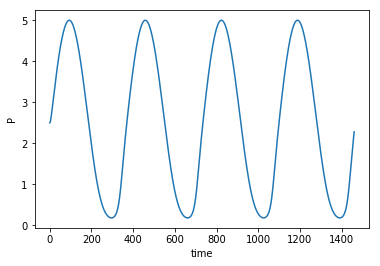

In [5]:
# implementation
theta = (γ,λ)
state = 2.5 # intial condition
times = np.arange(T+1) # output times
# call ODE function
out = odeint(Pgrowth, state, times, args=(γ,λ))

fig, ax = plt.subplots()
ax.plot(times, out)
ax.set(xlabel='time', ylabel='P')
None

## Stochasticity - single realization

### Approach 1: adding stochasticity using additive, signal-scaled white noise

In [6]:
P = np.full(nt, fill_value=np.nan)
P[0] = 2.5 # initial condition

for k in range(1,nt):
    time = k*dt
    noise = np.sqrt(dt)*0.05*P[k-1]*np.random.normal()
    P[k] = P[k-1] + dt*(γ*(1+np.sin(om*time))*P[k-1] - λ*P[k-1]**2) + noise

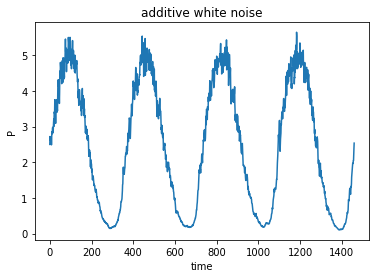

In [7]:
fig, ax = plt.subplots()
ax.plot(range(0,dt*nt,dt), P)
ax.set(title='additive white noise', xlabel='time', ylabel='P')
None

In [8]:
P = np.full(nt, fill_value=np.nan)
P[0] = 2.5 # initial condition

for k in range(1,nt):
    time = k*dt
    gammas = np.random.lognormal(mean=np.log(0.25), sigma=0.05)
    lambdas = np.random.uniform(low=0.08, high=0.12)
    P[k] = P[k-1] + dt*(gammas*(1+np.sin(om*time))*P[k-1] - lambdas*P[k-1]**2)

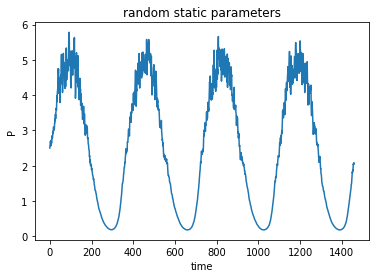

In [9]:
fig, ax = plt.subplots()
ax.plot(range(0,dt*nt,dt), P)
ax.set(title='random static parameters', xlabel='time', ylabel='P')
None

### Approach 2: parameters are dynamic, follow stochastic process AR(1)

In [10]:
nday = 365
dgamma = np.zeros(nday)
dlambda = np.zeros(nday)

for k in range(1,nday):
    dgamma[k] = 0.9*dgamma[k-1] + 0.01*np.random.normal()
    dlambda[k] = 0.9*dlambda[k-1] + 0.01*np.random.normal()

gammat = γ + dgamma
lambdat = λ + dlambda

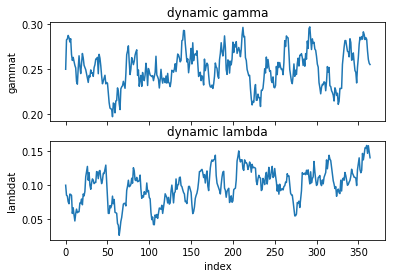

In [11]:
fig, axs = plt.subplots(nrows=2, sharex=True)
axs[0].plot(gammat)
axs[0].set(title='dynamic gamma', ylabel='gammat')
axs[1].plot(lambdat)
axs[1].set(title='dynamic lambda', xlabel='index', ylabel='lambdat')
None

In [12]:
P = np.full(nt, fill_value=np.nan)
P[0] = 2.5 # initial condition

dgamma = 0.0
dlambda = 0.0
for k in range(1,nt):
    time = k*dt
    dgamma = 0.9*dgamma + 0.01*np.random.normal()
    dlambda = 0.9*dlambda + 0.01*np.random.normal()
    P[k] = P[k-1] + dt*((γ+dgamma)*(1+np.sin(om*time))*P[k-1] - (λ+dlambda)*P[k-1]**2)

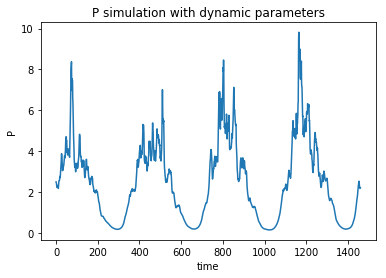

In [13]:
fig, ax = plt.subplots()
ax.plot(range(0,dt*nt,dt), P)
ax.set(title='P simulation with dynamic parameters', xlabel='time', ylabel='P')
None

## Ensembles

### Approach 1: parameters follow pdf, one parameter set per realization

In [14]:
nr = 50
Pacc = np.full((nt,nr), fill_value=np.nan)

P = np.full(nt, fill_value=np.nan)
P[0] = 2.5 # initial condition

for ir in range(nr):
    gammas = np.random.lognormal(mean=np.log(0.25), sigma=0.05)
    lambdas = np.random.uniform(low=0.08, high=0.12)
    for k in range(1,nt):
        time = k*dt
        P[k] = P[k-1] + dt*(gammas*(1+np.sin(om*time))*P[k-1] - lambdas*P[k-1]**2)
    Pacc[:,ir] = P

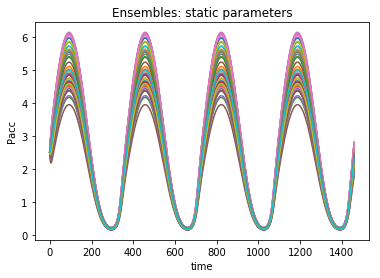

In [15]:
fig, ax = plt.subplots()
ax.plot(range(0,dt*nt,dt), Pacc)
ax.set(title='Ensembles: static parameters', xlabel='time', ylabel='Pacc')
None

### Approach 2: parameters are dynamic (AR)

In [16]:
nr = 100
Pacc = np.full((nt,nr), fill_value=np.nan)

P = np.full(nt, fill_value=np.nan)
P[0] = 2.5 # initial condition

dgamma = 0.0
dlambda = 0.0
for ir in range(nr):
    for k in range(1,nt):
        time = k*dt
        dgamma = 0.9*dgamma + 0.01*np.random.normal()
        dlambda = 0.9*dlambda + 0.01*np.random.normal()
        P[k] = P[k-1] + dt*((γ+dgamma)*(1+np.sin(om*time))*P[k-1] - (λ+dlambda)*P[k-1]**2)
    Pacc[:,ir] = P

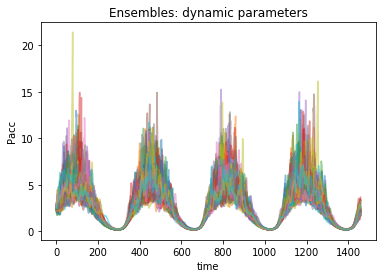

In [17]:
fig, ax = plt.subplots()
ax.plot(range(0,dt*nt,dt), Pacc, alpha=0.5)
ax.set(title='Ensembles: dynamic parameters', xlabel='time', ylabel='Pacc')
None

## Visualization and summary stats

### statistics and samples

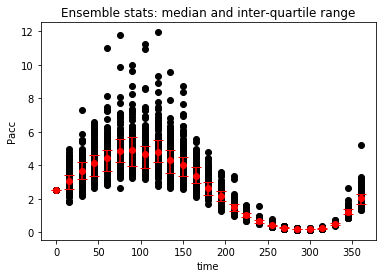

In [18]:
# medians (for each time)
Pmed = np.median(Pacc, axis=1)

# quantiles 
Pupper = np.percentile(Pacc, 75, axis=1)

Plower = np.percentile(Pacc, 25, axis=1)

# subsample on coarser time interval (to aid in visualization)
idx = range(0,365,15)

fig, ax = plt.subplots()
ax.plot(idx, Pacc[idx,:], marker='o', linestyle='none', color='black')
ax.errorbar(x=idx, y=Pmed[idx], yerr=[Pupper[idx]-Pmed[idx],Pmed[idx]-Plower[idx]], 
            color='red', zorder=5, linestyle='none', marker='o', capsize=5)
ax.set(title='Ensemble stats: median and inter-quartile range', xlabel='time', ylabel='Pacc')
None